# STOCK TRADING

Stock trading agent based on PPO

* Using state as:
    * Close (detrend)
    * Open (detrend)
    * High (detrend)
    * Low (detrend)
    * Predicted (detrend)
    * Holdings
    * Cash
    * Port value
    * Avg price paid

In [1]:
!pip install opencv-python

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
import os
import sys
import gym
import argparse
import numpy as np
import pandas as pd
import json
import tensorflow as tf
from scipy import signal
import matplotlib.pyplot as plt

from PPO.ppo import PPO

from keras.backend.tensorflow_backend import set_session
from keras.utils import to_categorical

from core.market_env_v1 import MarketEnvironmentV1
from utils.networks import get_session

In [ ]:
gym.logger.set_level(40)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Load data

In [ ]:
df = pd.read_csv('data/EURUSD_15m_BID_01.01.2010-31.12.2016.csv')
df

In [ ]:
OHLC = df[['Open', 'High', 'Low', 'Close', 'Volume']].values

In [ ]:
fig1 = plt.figure(facecolor='white')
ax1 = fig1.add_subplot(111)
plt.plot(OHLC[:, 3])
plt.show()

### Detrend

In [ ]:
x_train = np.zeros(OHLC.shape)

In [8]:
x_train[:, 0] = signal.detrend(OHLC[:, 0])
x_train[:, 1] = signal.detrend(OHLC[:, 1])
x_train[:, 2] = signal.detrend(OHLC[:, 2])
x_train[:, 3] = signal.detrend(OHLC[:, 3])
x_train[:, 4] = signal.detrend(OHLC[:, 4])

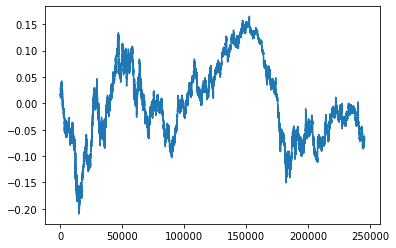

In [9]:
fig1 = plt.figure(facecolor='white')
ax1 = fig1.add_subplot(111)
plt.plot(x_train[:, 3])
plt.show()

### Env space

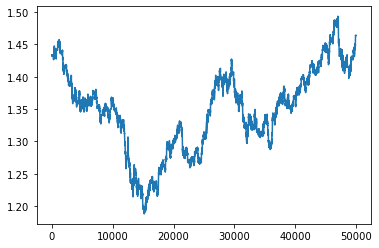

In [10]:
fig1 = plt.figure(facecolor='white')
ax1 = fig1.add_subplot(111)
plt.plot(OHLC[0:50000, 3])
plt.show()

## Hyperparameters

In [11]:
### MODEL HYPERPARAMETERS
seq_len = 100
num_cols = 9 # OHLC and others

# Here our possible actions
sit = [1, 0, 0]
buy = [0, 1, 0]
sell = [0, 0, 1]
possible_actions = [sit, buy, sell]
state_size = (5, 1) # (close, open, high, low, )
action_size = 3              # 3 possible actions: sit, buy, sell

# Learning Hyper parameters
learning_rate =  0.001
reward_function =  'SimpleProfit' # policy function

### TRAINING HYPERPARAMETERS
total_episodes = 5000
batch_size = 1024

# Exploration parameters for epsilon greedy strategy
explore_start = 0.6            # exploration probability at start
explore_stop = 0.1            # minimum exploration probability 
decay_rate = 0.01            # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.999               # Discounting rate


### MEMORY HYPERPARAMETERS
pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
memory_size = 20000          # Number of experiences the Memory can keep

### PPO Params
profit_window_size = 10
close_col = 3
buffer_size = 1024
epochs = 10
initial_cash = 5.0
loss_clipping = 0.2
noise = 1.0
entropy_loss = 5e-3

gpu = True
gather_stats = True
env_name = 'Market'
type = 'PPO'
consecutive_frames = 4


### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = True

## Environment

In [13]:
# Environment Initialization
env = MarketEnvironmentV1(x_train, possible_actions, state_size, 
                        start_index=0,
                        end_index=50000,
                        close_col=close_col, 
                        undo_detrend=OHLC,  
                        profit_window_size=profit_window_size)
env.reset()
state_dim = env.get_state_size()[0]
action_dim = env.get_action_size()

## Init logs

In [14]:
tensorboard_logs = type + "/tensorboard_" + env_name + "_v0.3"

In [15]:
!mkdir $tensorboard_logs

# Clear any logs from previous runs
import shutil
shutil.rmtree(tensorboard_logs)

mkdir: cannot create directory ‘PPO/tensorboard_Market_v0.3’: File exists


In [16]:
set_session(get_session())
summary_writer = tf.summary.FileWriter(tensorboard_logs)

## Setting up the algo

In [17]:
layers = [
			{
				"type": "dense",
				"neurons": 32,
				"activation": "tanh",
				"is_input": True
			},
			{
				"type": "dense",
				"activation": "tanh",
				"neurons": 32
			},
			{
				"type": "dense",
				"activation": "tanh",
				"neurons": 8
			},
			{
				"type": "dense",
				"activation": "tanh",
				"neurons": 32
			},
			{
				"type": "dense",
				"activation": "tanh",
				"neurons": 8
			},
			{
				"type": "dense",
				"is_output": True,
				"activation": "softmax"
			}
		]

In [18]:
algo = PPO(action_dim, state_dim, consecutive_frames, 
           lr=learning_rate, gamma=gamma, layers=layers,
          loss_clipping=loss_clipping, noise=noise, entropy_loss=entropy_loss)






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
actor_input (Dense)          (None, 32)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
_________________________________________________________________
actor_output (Dense)         (None, 3)                 27        
Total

## Training

In [ ]:
rewards, actor_losses, critic_losses = algo.train(env, summary_writer, debug=False, 
                    batch_size=batch_size, buffer_size=buffer_size, epochs=epochs, nb_episodes=total_episodes)

Score per bash:   0%|          | 0/5000 [00:00<?, ? episodes/s]

--------------------------------------------------
Traning with parameters:
	- learning_rate:  0.001
	- batch_size:  1024
	- buffer_size:  1024
	- epochs:  10
	- loss_clipping:  0.2
	- noise:  1.0
	- entropy_loss:  0.005
	- profit_window_size:  10
--------------------------------------------------





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Score per bash: -102.66213864909244:   5%|▍         | 232/5000 [1:30:09<29:17:16, 22.11s/ episodes]

In [22]:
rewards = algo.batch_rewards

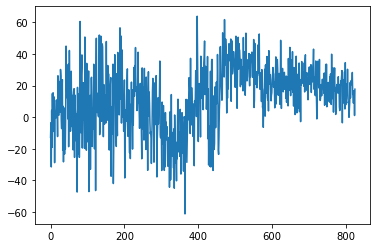

In [23]:
import matplotlib.pyplot as plt
plt.plot(np.array(rewards).clip(-1e2,1e4))
plt.show()

In [21]:
import datetime
now = datetime.datetime.now().strftime("%S-%M-%H_%d-%m-%Y")
weights_filename = "saved_models/PPO_" + now + "_"
algo.save_weights(weights_filename)

## TEsting

In [24]:
args = {
    'x': x_train, 
    'actions': possible_actions, 
    'state_size': state_size, 
    'start_index': 0,
    'end_index': 5000,
    'close_col': close_col, 
    'undo_detrend': OHLC, 
    'profit_window_size': profit_window_size, 
}
env = MarketEnvironmentV1(**args)

In [25]:
algo = PPO(action_dim, state_dim, consecutive_frames, is_eval=True,
           lr=learning_rate, gamma=gamma, layers=layers,
          loss_clipping=loss_clipping, noise=noise, entropy_loss=entropy_loss)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
actor_input (Dense)          (None, 32)                192       
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_11 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 264       
_________________________________________________________________
actor_output (Dense)         (None, 3)                 27        
Total para

In [26]:
weights_filename

'saved_models/PPO_48-29-01_13-09-2021_'

In [28]:
algo.load_weights(
    "saved_models/PPO_48-29-01_13-09-2021__LR_0.001_actor.h5", 
    "saved_models/PPO_48-29-01_13-09-2021__LR_0.001_critic.h5"
)

In [29]:
def buy():
    states_sell = []
    states_buy = []
    close = []
    
    observation = env.reset()
    done = False
    t = 0 

    while not done:
        close.append(env.get_last_close())
        action = algo.policy_action(np.array(observation))
        if action == 1: states_buy.append(t)
        if action == 2: states_sell.append(t)
            
        observation, r, done, _ = env.step(action)
        
        t += 1
        
    info = env.get_info()
    return close, states_buy, states_sell

In [30]:
close, states_buy, states_sell = buy()

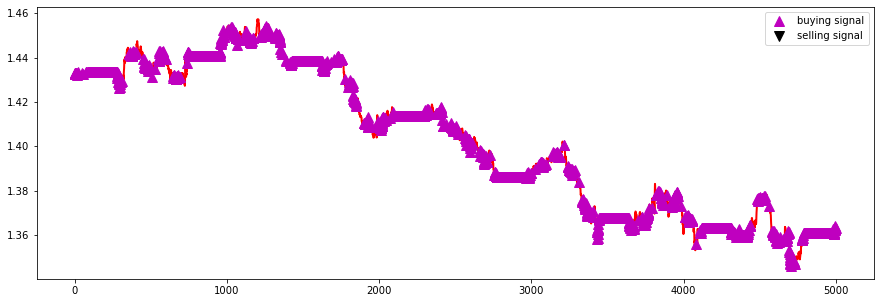

In [31]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
# plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()